In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
tau_vals = [0.1, 0.3, 0.5, 0.9, 0.99]


# Multi-quantile estimations

In [2]:
# Dataset generation
distros = ['mix', 'gau_1', 'gau_2', 'exp']

def get_one_dt(distro, datasize):
#     return np.ones(size)
    if distro == 'gau_1':
        return np.random.normal(2, 18, datasize)
    elif distro == 'gau_2':
        return np.random.normal(0, 0.001, datasize)
    elif distro == 'mix':
        # mean: -1.3
        # std: 30.779035604224564
        # var: 947.3490327261234
        mix_lst = np.zeros(datasize)
        sizes = np.array([0.3, 0.2, 0.1, 0.15, 0.25])
        mixtures = [(2,7), (0,0.7), (36, 26), (5,77), (-77,7)]
        acc_sizes = [sum(sizes[:i+1]) for i in range(len(sizes))]

        for d_idx in range(datasize):
            rdn = np.random.uniform(0,1)
            mix_id = 0
            for m_id in acc_sizes:
                if rdn > m_id:
                    mix_id += 1
                else:break
            data_point = np.random.normal(mixtures[mix_id][0], mixtures[mix_id][1])
            mix_lst[d_idx] = data_point
        return mix_lst
    elif distro == 'exp':
        return np.random.exponential(scale=1, size=datasize)*6.5 - 20
    else: raise Exception("distribution doesn't work!")

In [3]:
# dt = get_one_dt('exp', 10000)
# plt.hist(dt, bins=100)

## Joint Tracking of Multiple Quantiles Through Condition Quantiles

1. Algo based on DUMIQUE (basically SGD but claim itself not ablt to deal with non-positive quantiles directly)

In [4]:
# not sure why *q_est --> Cannot deal with q_est<0
def DUMIQUE(q_est, x, tau, stepsize):
    if q_est < 0: raise Exception("!!!", q_est)
    if x > q_est:
        q_est += (stepsize*q_est)*tau
    else:
        q_est += (stepsize*q_est)*(tau-1)
    return q_est

# SGD which works for q_est non positive, only constant stepsize
def sgd(q_est, x, tau, stepsize):
    if x > q_est:
        q_est += stepsize*tau
    else:
        q_est += stepsize*(tau-1)
    return q_est

In [5]:
def checkinput(q_est):
    q_new = [-0.001]
    q_new.extend([q_est[i] for i in range(len(q_est)-1)])
    for i in range(len(q_est)):
        if q_new[i] >= q_est[i]: return False
    return True

# sX is stepsize_X, sY is stepsize_Y
# c = 2 because 0.5 is at tau_vals[2]
def shiftQ(dataset, tau_lst, sX, sY, qX, qY, c=0):
    if not (checkinput(qX) and checkinput(qY)):
        raise Exception("Input quantile estimate not applicable")
    count = 0
    proc = np.zeros((len(dataset), len(tau_lst)))
    for i, x in enumerate(dataset):
        qX[c] = DUMIQUE(qX[c], x, tau_lst[c], sX)

        for k in range(c-1, -1, -1):
            tau = tau_lst[k]
#           shifted observation
            yk = qX[k+1] - x
#           shifted Y distro
            qY[k] = DUMIQUE(qY[k], yk, 1-tau, sY)
#           shift back
            qX[k] = qX[k+1] - qY[k]
#             print ('yk', yk)
#             print ('qY', qY)
#             print ('qX', qX)
        
        for k in range(c+1, len(qX)):
            tau = tau_lst[k]
            yk = -qX[k-1] + x
            qY[k] = DUMIQUE(qY[k], yk, tau, sY)
            qX[k] = qX[k-1] + qY[k]
#             print ('yk',yk)
#             print ('qY', qY)
#             print ('qX', qX)
#         print ('qY', qY)
        if not (checkinput(qX)):
            count += 1
        proc[i] = qX
    print ("shiftQ Overall crossing", count)
    return proc


shiftQ Overall crossing 0


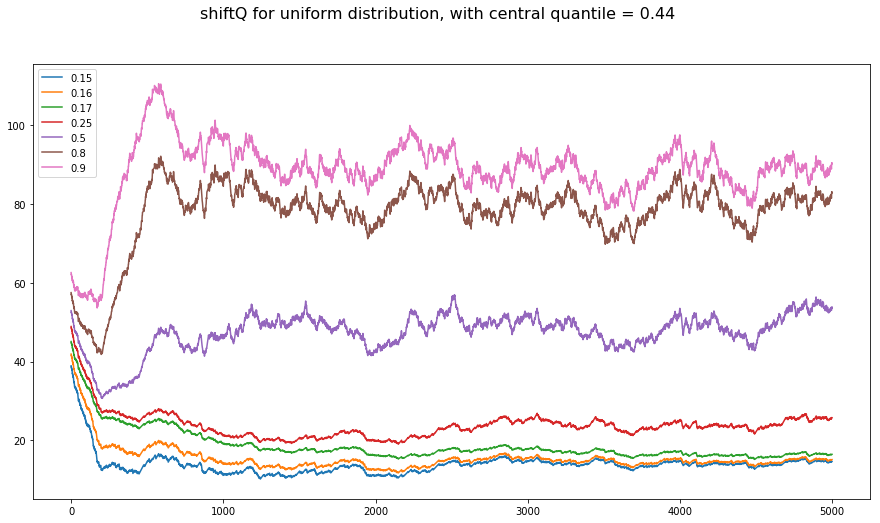

[[14.52265116 15.00465457 16.35632022 25.57952964 53.69880236 83.10650993
  90.49996429]
 [14.55622824 15.03678565 16.38412596 25.65345144 53.49153142 82.78160816
  90.16027562]
 [14.58983442 15.06895015 16.41197898 25.72765108 53.84411187 83.0170283
  90.38093842]]


In [6]:
dataset = np.random.uniform(0, 100, 5000)
qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])
qY = np.asarray([30.0, 32, 36, 38, 40.0, 45, 50])/10.0
tau_lst = [0.15, 0.16, 0.17, 0.25, 0.5, 0.8, 0.9]
proc = shiftQ(dataset, tau_lst, 0.01, 0.02, qX, qY, 2)
# print (proc)
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
ax.plot(proc)
ax.legend(tau_lst)
fig.suptitle("shiftQ for uniform distribution, with central quantile = 0.44", fontsize = 16)
plt.show()

print (proc[-3:, :])


#### Explanation

1. **Overall:** The basic idea is to estimate a central quantile point, and update other quantiles based on the central one. 

2. **Motivation:** The difference $diff$ between the two quantiles for the $x_{n}$ observation is:
$$
diff = |Q_x(q_{k+1}) - Q_x(q_k)|
$$
    Note that $diff > 0$ for all time, so different quantiles never cross each other. This property is guaranteed by the update function DUMIQE() and its restriction that the input quantile estimate must > 0.

2. **Update one quantile:** The difference is calculated based on the idea of "shift distribution". Let $X$ denotes the original distribution of data stream, and let distribution $Y$ denotes a shifted version of $X$ such that $Y = X + constant$. In this way, the quantile $q_{k+1}$ can be updated by implementation of shifting. The basic steps are:
    1. Calculate $Q_x(q_k)$, which is the shift constant
    2. Get shift observation $y_{k+1} =  Q_x(q_k) - x$
    3. Calculate the new quantile $Q_y(q_{k+1})$ in $Y$
    4. Shift the change back to $X$: $Q_x(q_{k+1}) = Q_y(q_{k+1}) + shiftConstant$

3. **Update the bigger quantiles:** Starting from central quantile $q_c$, the estimates for $q_{c+1}, ..., q_{K}$ are calculated one based on another. So each time step 2 is repeated from $q_c$ to $q_{K-1}$

4. **Update the smaller quantiles:** Similar to step 3, for smaller quantiles, estimates for $q_{c-1}, ..., q_{1}$ are calculated similarly one based on another.

#### Observation and Analysis

1. The quantiles greater than the central quantile work well. We can see the biggest 3 quantiles are converging close to the true quantiles.

2. The quantiles smaller than central quantile converges to the central quantile. Specially, the smallest quantile first converge to the second one, then the second one to the third one, until all of the small ones converge to the central one.
    
    **Explanation:**
    
    Let's assume $Q_x(q_{c-1})$ is already on it's track converging to $Q_x(q_c)$.
    On the arrival of new observation $x$, the update of $Q_x(q_{c-1})$ is 
    $$ Q_x(q_{c-1}) = Q_x(q_{c}) - Q_y(q_{c-1})$$
    We can observe from the data the difference $Q_y(q_{c-1})$ is decreasing. But I don't know why
    
    
    
    

### Comparison with SGD

In [7]:
def SGD(dataset, tau_lst, stepsize, q):
    count = 0
    if not (checkinput(q)):
        raise Exception("Input quantile estimate not applicable")
    proc = np.zeros((len(dataset), len(tau_lst)))
    for i, x in enumerate(dataset):
        for k in range(len(tau_lst)):
            tau = tau_lst[k]
            q[k] = sgd(q[k], x, tau, stepsize)
        if not (checkinput(q)):
            count += 1
#             print ("!!! Cross !!!", q)
        proc[i] = q
    print ("SGD overall crossings", count)
    return proc

SGD overall crossings 225


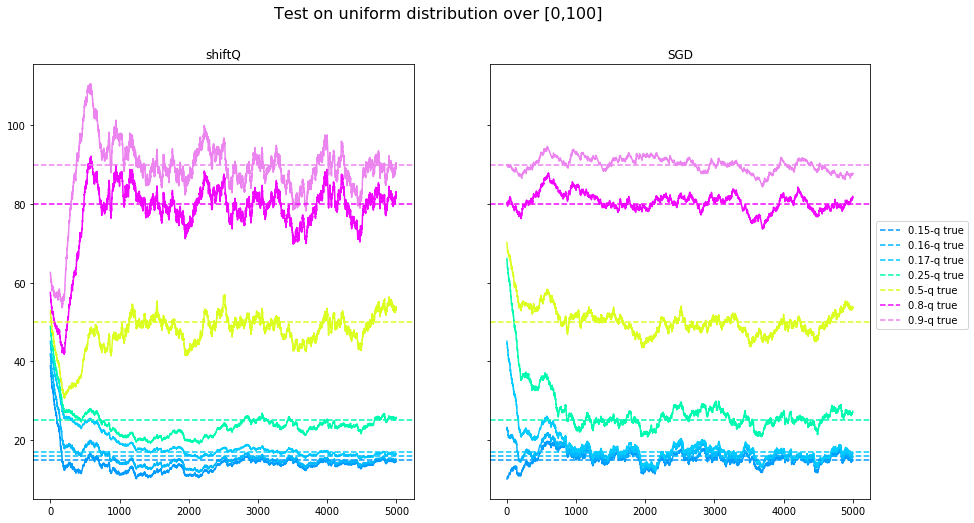

ShiftQ res [14.58983442 15.06895015 16.41197898 25.72765108 53.84411187 83.0170283
 90.38093842]
SGD res    [14.95 15.8  16.65 27.3  53.8  81.8  87.75]
True res   [15. 16. 17. 25. 50. 80. 90.]


In [8]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

c_Norm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('gist_ncar'))

qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])
# print (qX)
proc2 = SGD(dataset, tau_lst, 0.45, qX)
q_true = np.asarray(tau_lst)*100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8), sharey=True)

for idx, qt in enumerate(q_true):
    colorVal = scalarMap.to_rgba(tau_lst[idx])                
    ax.axhline(qt, linestyle='--', color=colorVal, label=(str(tau_lst[idx])+'-q true'))
            
for i, p in enumerate(proc.T): 
    colorVal = scalarMap.to_rgba(tau_lst[i])
    ax1.plot(p, color=colorVal)
ax1.set_title("shiftQ")


for i, p in enumerate(proc2.T):
    colorVal = scalarMap.to_rgba(tau_lst[i])                
    ax2.plot(p, color=colorVal)
# ax2.plot(proc2)
ax2.set_title("SGD")



# print (q_true)

for i, qt in enumerate(q_true):
    colorVal = scalarMap.to_rgba(tau_lst[i])               
    ax1.axhline(qt, linestyle='--', color = colorVal, label=(str(tau_lst[i])+'-q true'))
    ax2.axhline(qt, linestyle='--', color = colorVal, label=(str(tau_lst[i])+'-q true'))

# lgd =  ([(str(t)+'-quantile') for t in tau_lst])
# ax1.legend(lgd)
lgd = ax1.legend(bbox_to_anchor=(2.47, 0.65), ncol = 1)

fig.suptitle("Test on uniform distribution over [0,100]", fontsize=16)
plt.show()
fig.savefig("shiftQ_vs_SGD.png", bbox_extra_artists=[lgd, fig], bbox_inches='tight')

print ("ShiftQ res", proc[-1, :])
print ("SGD res   ", proc2[-1, :])
print ("True res  ", q_true)

Obviously SGD is better: it at least conveges to the correct value. But **crossing problem not solved**

## Joint Tracking of Multiple Quantiles Through Condition Quantiles

Algo based on QEWA -- Too complicated, not going to implement this now


### Tracking Quantiles of Network Data Streams with Dynamic Options

Jin Cao, ...

Not going to implement this

## P2

Exponentially Weighted Simultaneous Esimation of Several Quantiles

In [9]:
# def p2extend_tau(tau_lst):
#     help_lst = np.zeros(len(tau_lst)+2)
#     for i,x in enumerate(tau_lst):
#         help_lst[i+1] = x
#     help_lst[-1] = 1
    
#     ext_tau_lst = np.zeros(len(tau_lst)*2+1)
#     for i in range(len(ext_tau_lst)):
#         k = int(i/2)
#         if i%2 == 0:
#             ext_tau_lst[i] = (help_lst[k] + help_lst[k+1])*0.5
#         else:
#             ext_tau_lst[i] = help_lst[k+1]
#     return ext_tau_lst

# # p2extend([0.1, 0.2, 0.5, 0.66, 0.7])
# def p2extend_q(q_lst):
#     ext_q_lst = np.zeros(len(q_lst)*2+1)
#     for i in range(len(q_lst)):
#         k = i*2 + 1
#         ext_q_lst[k] = q_lst[i]
#         if i != len(q_lst)-1:
#             ext_q_lst[k+1] = (q_lst[i] + q_lst[i+1]) * 0.5  
#     ext_q_lst[0]  = 0.5*q_lst[0]  - 0.5*q_lst[1]
#     ext_q_lst[-1] = 1.5*q_lst[-1] - 0.5*q_lst[-2]
#     return ext_q_lst
# # p2extend_q([-0.1, 2, 5, 66, 67])

In [10]:
# def update_tau_star(u, tau_star, x, q):
#     if x <= q:
#         return (1-u)*tau_star + u
#     else: return (1-u)*tau_star

# # update_tau_star(0.001, 2, 10, 8)
# def update_q(tau, tau_star, tau_star_minus, tau_star_plus, q, q_minus, q_plus):
#     q = q + (tau-tau_star)/(tau_star_plus - tau_star_minus) \
#         * ( \
#             (tau - tau_star_minus) * (q_plus - q)/(tau_star_plus - tau_star) \
#           + (tau_star_plus - tau) * (q - q_minus)/(tau_star - tau_star_minus) \
#         )
#     return q
# def p2update(u, x, ext_tau_lst, tau_star_lst, ext_q_lst):
#     m = len(ext_tau_lst)
#     k = int((m-1)/2)
# #     internal_idx = [(i*2+3) for i in range(0, k-2)]
# #     external_idx = [1, -2]
    
# #     update all tau_stars
#     for i in range(m):
#         q = ext_q_lst[i]
#         tau_star = tau_star_lst[i]
# #         print ("tau_star", tau_star)
#         tau_star_lst[i] = update_tau_star(u, tau_star, x, q)
        
# #     adjust internal points
#     for i in range(1,m):
#         tau = ext_tau_lst[i]
#         tau_star = tau_star_lst[i]
#         tau_star_minus, tau_star_plus = tau_star_lst[i-1], tau_star_lst[i+1]
        
#         q = ext_q_lst[i]
# #         print ("q", q)
#         q_minus, q_plus = ext_q_lst[i-1], ext_q_lst[i+1]

#         ext_q_lst[i] = update_q(tau, tau_star, tau_star_minus, tau_star_plus, q, q_minus, q_plus)
# #         print ("tau", tau)
# #         print ("tau_star after", tau_star)
# #         print ("tau_star_minus", tau_star_minus)
# #         print ("tau_star_plus", tau_star_plus)
# #         print ("q", q)
# #         print ("q_minus", q_minus)
# #         print ("q_plus", q_plus)
        

In [11]:
# # modified p2, since the tails are processed with exponential smooth curve
# def mp2(dataset, tau_lst, q_start=None):
#     if q_start is not None and len(tau_lst) != len(q_start):
#         raise Exception("tau list {} (len {})\n and q_start {} (len {}) dones't match!"
#                         .format(tau_lst, len(tau_lst), q_start, len(q_start)))
#     ext_tau_lst = p2extend_tau(tau_lst)
#     tau_star_lst = ext_tau_lst.copy()
    
#     k = len(tau_lst)
#     m = k*2+1
#     ext_q_lst = np.asarray(dataset[:m])
        
#     proc = np.zeros((len(dataset)-m, len(tau_lst)))
#     proc_ext = np.zeros((len(dataset)-m, len(ext_tau_lst)))
    
#     u = 1/len(dataset)
#     for idx, x in enumerate(dataset[m:]):
# #         p2update(0.001, x, ext_tau_lst, tau_star_lst, ext_q_lst)
#         ext_q_lst, ext_tau_lst = p2update(u, x, ext_tau_lst, tau_star_lst, ext_q_lst)

#         proc_ext[idx] = ext_q_lst
# #         proc[idx] = [ext_q_lst[i*2+1] for i in range(k)]
        
#     return proc_ext

In [12]:
# rdn = np.random.randint(0, 100, 20)
# print (rdn)
# mp2(rdn, tau_lst, [-10, 2, 5, 66, 67, 99, 108])

In [13]:
def extend_tau_lst(tau_lst):
    # extend tau_lst from [tau_1, ... tau_k] to 
    # [tau_1/2, tau_1, (tau_1 + tau_k)/2]
    k = len(tau_lst)
    help_lst = np.zeros(k+2)
    for i,x in enumerate(tau_lst):
        help_lst[i+1] = x
    help_lst[-1] = 1
    
    m = k*2+1
    ext_tau_lst = np.zeros(m)
    for i in range(len(ext_tau_lst)):
        k = int(i/2)
        if i%2 == 0:
            ext_tau_lst[i] = (help_lst[k] + help_lst[k+1])*0.5
        else:
            ext_tau_lst[i] = help_lst[k+1]
            
    ext_two_lst = np.zeros(m+2)
    ext_two_lst[0] = 0
    ext_two_lst[-1] = 1
    for i, t in enumerate(ext_tau_lst):
        ext_two_lst[i+1] = t
    
    return ext_two_lst

# # test
print (extend_tau_lst([0.01, 0.2, 0.5, 0.6, 0.9]))

def adjust_tau_star(x, u, tau_star_lst, q_lst):
    for i, t in enumerate(tau_star_lst):
        q = q_lst[i]
        if x <= q:
            t = (1-u)*t + u
        else:
            t = (1-u)*t
        tau_star_lst[i] = t
    return tau_star_lst

# adjust_tau_star(10, 0.01, [0.1, 0.2, 0.3], [1, 2, 11])


# 0.155 0.27145108 0.18612348 0.48402171 5 2 8
def update_q(tau, tau_star, tau_star_minus, tau_star_plus, q, q_minus, q_plus):
    adding = (tau-tau_star)/(tau_star_plus - tau_star_minus) * \
            ((tau - tau_star_minus) * (q_plus - q)/(tau_star_plus - tau_star) \
          + (tau_star_plus - tau) * (q - q_minus)/(tau_star - tau_star_minus) \
        )

    q += adding
    return q


def update_internal_q(ext_q_lst, ext_tau_lst, tau_star_lst):
    m = len(ext_tau_lst)-2    
    temp = ext_q_lst.copy()
    not_crossing = (sorted(temp) == temp).all()
    
#     print (not_crossing)
    for i in range(1,m+1):
#         print (ext_tau_lst[i])
        tau = ext_tau_lst[i]
        tau_star = tau_star_lst[i]
        tau_star_minus, tau_star_plus = tau_star_lst[i-1], tau_star_lst[i+1]
#         print("taus: {}, {}, {}".format(tau_star_minus, tau_star, tau_star_plus))
        q = ext_q_lst[i]
        q_minus, q_plus = ext_q_lst[i-1], ext_q_lst[i+1]
#         print ("q_min <= q <= q_plus{}, {}, {}".format(q_minus, q, q_plus))
        
#         if i == 3:
#             print (tau, tau_star, tau_star_minus, tau_star_plus, q, q_minus, q_plus)
#         temp[i] = update_q(tau, tau_star, tau_star_minus, tau_star_plus, q, q_minus, q_plus)

        adding = 0
#         not_crossing = (q_minus <= q and q <= q_plus)
        if (not_crossing):
            adding = (tau-tau_star)/(tau_star_plus - tau_star_minus) * \
                ((tau - tau_star_minus) * (q_plus - q)/(tau_star_plus - tau_star) \
              + (tau_star_plus - tau) * (q - q_minus)/(tau_star - tau_star_minus) \
            )
        else:
            if tau >= tau_star:
                adding = (q_plus - q) * (tau - tau_star)/(tau_star_plus - tau_star)
            else:
                adding = (q - q_minus) * (tau - tau_star)/(tau_star - tau_star_minus)
                

        temp[i] += adding
    
#         print ("{} => {}".format(ext_q_lst[i], temp[i]))
    return temp


# ext_q_lst = [ 1,  1,  2,  5,  8,  8, 12, 15, 18, 19, 19]     
# ext_tau_lst = [0.0025, 0.005, 0.01 , 0.155, 0.3  , 0.4  , 0.5  , 0.6  , 0.7  , 0.85, 0.925 ]    
# tau_star_lst = [0.06397169, 0.06489669, 0.18612348, 0.27145108, 0.48402171, 0.52102184,
#  0.58953695, 0.65562462, 0.75834933, 0.81384954, 0.87585012]
# update_internal_q(ext_q_lst, ext_tau_lst, tau_star_lst)


# update_q(, tau_star, tau_star_minus, tau_star_plus, q, q_minus, q_plus)
# adjust_tau_star(10, 0.01, [0.1, 0.2, 0.3], [1, 2, 11])

[0.    0.005 0.01  0.105 0.2   0.35  0.5   0.55  0.6   0.75  0.9   0.95
 1.   ]


In [14]:
# extend_tau_lst([0.01, 0.2, 0.5, 0.6, 0.9])
def is_valid_tau_lst(q_est, delta):
    q_new = [-0.001]
    q_new.extend([q_est[i] for i in range(len(q_est)-1)])
    for i in range(len(q_est)):
        if q_new[i] >= q_est[i]-delta: return False
        if q_est[i] < 0 : raise Exception ("tau list < 0")
    return True

is_valid_tau_lst([1, 2, 3.00005, 3], 0.000001)

def fix_crossing(lst, delta):
    lst = np.sort(lst)
    if not is_valid_tau_lst(lst, delta):
        for i in range(len(lst)): lst += delta*i
    return lst
# fix_crossing([1, 2, 3.00005, 3], 0.000001)

def is_ok_tau_star_crossing(ext_tau_lst, tau_star_lst):
    l = len(ext_tau_lst)
    rtn = True
    for j in range(1,l-1):
        if not (ext_tau_lst[j]<tau_star_lst[j+1] and ext_tau_lst[j]>tau_star_lst[j-1]):
            print ("tau value at {} is outside the tau_star_lst \n Left side: {}, right side {},\n list {}"
                   .format(j, ext_tau_lst[j]>tau_star_lst[j-1], ext_tau_lst[j]<tau_star_lst[j+1],
                          [tau_star_lst[j-1], ext_tau_lst[j], tau_star_lst[j+1]]))
            rtn = False
    return rtn

In [15]:
def mp2(dataset, tau_lst):
    k = len(tau_lst)
    m = 2*k + 1
    u = 1/(len(dataset)) * 1
    # 0 < p1 < p2 < ... < pm < 1
    ext_tau_lst = extend_tau_lst(tau_lst)
    if (len(ext_tau_lst)!= m+2): raise Exception("len(ext_tau_lst)"+str(len(ext_tau_lst))+" m is "+str(m))
    # h0 < h1 < ... < h(m+1)
    ext_q_lst = np.sort(dataset[:m+2])
    min_x, max_x = ext_q_lst[0], ext_q_lst[-1]

    if (len(ext_q_lst)!= m+2): raise Exception("len(ext_q_lst)"+str(len(ext_q_lst))+" m is "+str(m))

#     print ("ext_q_lst", ext_q_lst)
    tau_star_lst = ext_tau_lst.copy()
    tau_star_reco = np.zeros((len(dataset)-(m+2), m+2))
    ext_q_reco = np.zeros((len(dataset)-(m+2), m+2))
    
    
    for i, x in enumerate(dataset[m+2:]):
        min_x = min(min_x, x)
        max_x = max(max_x, x)
        # update tau_stars
        tau_star_lst = adjust_tau_star(x, u, tau_star_lst, ext_q_lst)
        tau_star_reco[i] = tau_star_lst
        if not is_valid_tau_lst(tau_star_lst, 0.00001): 
            print ("tau_star crossing! at round", i)
            fix_crossing(tau_star_lst, 0.00001)
            raise Exception("tau star crossing!!!, {}".format(i))
        # update internal grids
        ext_q_lst = update_internal_q(ext_q_lst, ext_tau_lst, tau_star_lst)
        ext_q_lst[0], ext_q_lst[-1] = min_x, max_x
        ext_q_reco[i] = ext_q_lst
        
        if not is_ok_tau_star_crossing(ext_tau_lst, tau_star_lst):
            print ("round", i)
            break

    return tau_star_reco, ext_q_reco

In [16]:
def get_original_lst(ext_lst):
    m = len(ext_lst)-2
    k = int((m-1)/2)
    lst = np.zeros(k)
    for i in range (1, m):
        if i % 2 == 0: 
            lst[int(i/2)-1] = ext_lst[i]
            
    return lst

# a = [0.1, 0.3, 0.5, 0.7]
# b = extend_tau_lst(a)
# c = get_original_lst(b)
# print (a==c)

In [17]:
def test(tau_lst):
    print (extend_tau_lst(tau_lst))

    dt = np.random.normal(0, 1, 1000000)

    L = len((extend_tau_lst(tau_lst)))
#         print ("q start at", np.sort(dt[:L]))
    tau_s, q_lst= mp2(dt, tau_lst)

    return q_lst

N=1
tau_lst = [0.001, 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]

q_res_ext= test(tau_lst)
# q_res = get_original_lst(q_res_ext[-1])

import csv
with open('p2.csv', 'w', newline = '') as f:
    writer = csv.writer(f)
#     writer.writerow(np.round(extend_tau_lst(tau_lst), 4))
    for r in q_res_ext:
        writer.writerow(np.round(r, 5))
        

for i, q in enumerate(get_original_lst(q_res_ext[-1])):
    print ("q {}      {}".format(tau_lst[i], q)) 

[0.000e+00 5.000e-04 1.000e-03 5.500e-03 1.000e-02 3.000e-02 5.000e-02
 7.500e-02 1.000e-01 1.750e-01 2.500e-01 3.750e-01 5.000e-01 6.250e-01
 7.500e-01 8.250e-01 9.000e-01 9.250e-01 9.500e-01 9.700e-01 9.900e-01
 9.945e-01 9.990e-01 9.995e-01 1.000e+00]
q 0.001      -2.882150296515615
q 0.01      -2.1638052689063234
q 0.05      -1.5896361116923996
q 0.1      -1.2827856830628652
q 0.25      -0.8838891013259371
q 0.5      -0.35703013630345015
q 0.75      0.3681257013561924
q 0.9      1.2131257210532698
q 0.95      1.6614997052094023
q 0.99      2.6910244480134353
q 0.999      3.2401338636251573


In [18]:
q_res = np.genfromtxt('p2.csv', delimiter=',').T

print ('done')
print (q_res.shape)

done
(25, 999975)


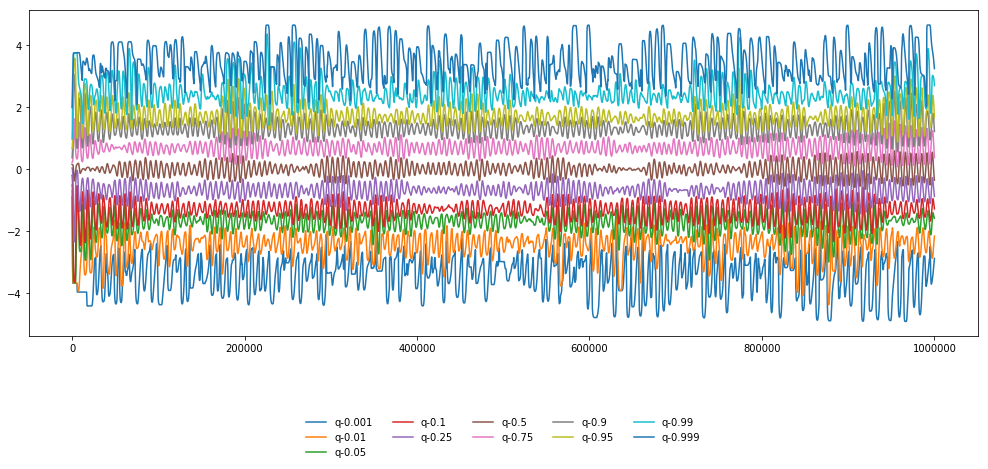

In [23]:
tau_lst = [0.001, 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
ext_tau_lst = np.round(extend_tau_lst(tau_lst), 4)

fig, (ax2) = plt.subplots(1, 1, figsize = (17, 6))
for i in range(len(tau_lst)):
    ax2.plot(q_res[(i+1)*2], label = 'q-{}'.format(tau_lst[i]))
# ax2.legend(ext_tau_lst)
lgd = ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
            frameon=False, ncol=5)
plt.show()

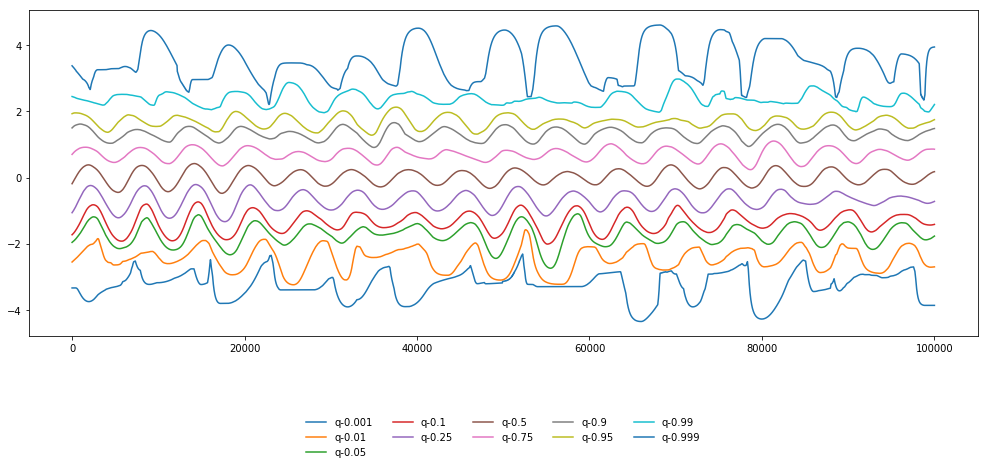

In [42]:
fig, (ax2) = plt.subplots(1, 1, figsize = (17, 6))
for i in range(len(tau_lst)):
    ax2.plot(q_res[(i+1)*2][300000:400000], label = 'q-{}'.format(tau_lst[i]))
# ax2.legend(ext_tau_lst)
lgd = ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
            frameon=False, ncol=5)
plt.show()

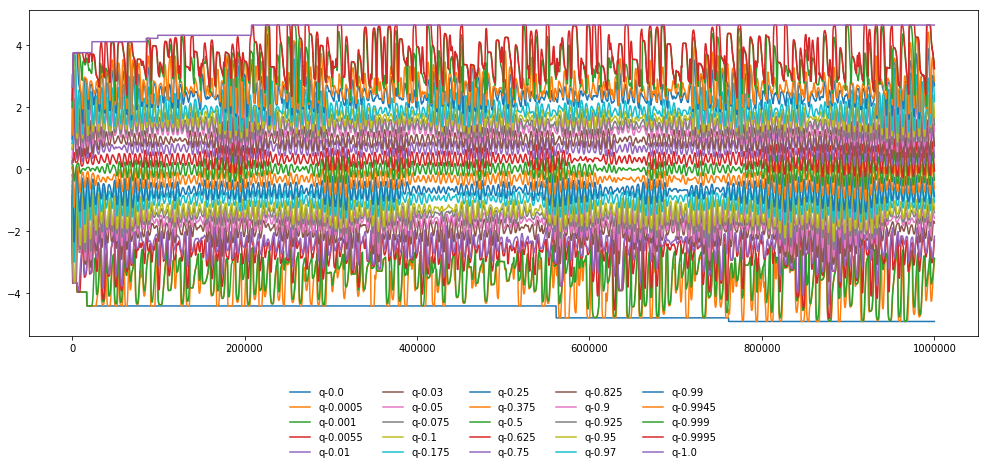

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (17, 6))
for i in range(q_res.shape[0]):
    ax.plot(q_res[i], label = 'q-{}'.format(ext_tau_lst[i]))
# ax2.legend(ext_tau_lst)
lgd = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
            frameon=False, ncol=5)
plt.show()